# Classification - Determine International Rating 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import re
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier, _fit_binary
from itertools import cycle, product
from sklearn.manifold import TSNE, MDS, Isomap
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
import time
from sklearn.ensemble import VotingClassifier
from joblib import Parallel, delayed

Using TensorFlow backend.


In [2]:
# Step 1. Prepare data

X:  (3563, 32)
1.0    3236
2.0     262
3.0      65
Name: International Reputation, dtype: int64
n_classes:  3


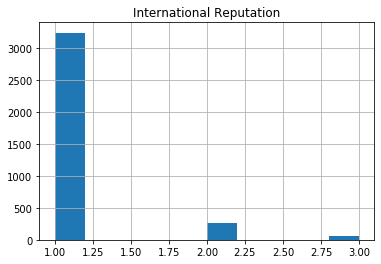

In [6]:
from sklearn.preprocessing import label_binarize

# Read original data
sample_data = pd.read_csv('fifa19_features_reduced_data.csv', encoding='utf-8')

# Separate internation rating result with rest
y = sample_data['International Reputation']
X = sample_data.drop('International Reputation', axis=1)
print('X: ', X.shape)

# Binarize the rating result
# Rating score 5 records is only 6 / 18208, so it cannot be predicated with too little data,
# we convert the score 5 and 4 to 3, so only choose rating scores 1, 2, 3 to classify.
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 5] = 3
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 4] = 3
sample_data.hist(column='International Reputation')
y_n = sample_data['International Reputation']

print(sample_data['International Reputation'].value_counts())

y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]
print('n_classes: ', n_classes)

X_train:  (2375, 32) X_test:  (1188, 32)
Rating Score value counts:  1
1    2162
0     213
dtype: int64


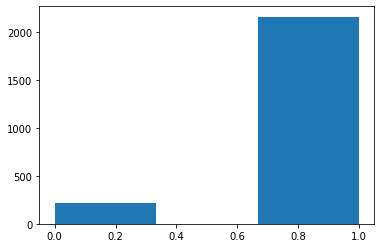

 
Rating Score value counts:  2
0    2203
1     172
dtype: int64


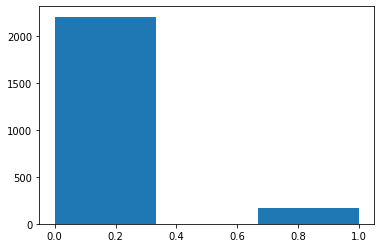

 
Rating Score value counts:  3
0    2334
1      41
dtype: int64


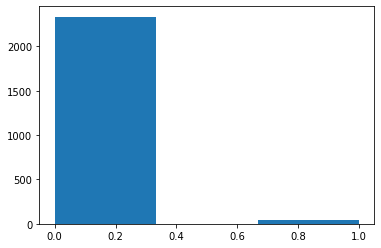

 
X_n_train:  (2375, 32) y_n_ftest:  (1188, 32)


In [7]:
# Divide data into training set and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=1)
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

#print(y_train)
for i in range(n_classes):
    print("Rating Score value counts: ", i + 1)
    print(pd.value_counts(y_train[:, i]))
    plt.hist(y_train[:, i], bins=3)
    plt.show()
    print(" ")

X_n_train,X_n_test,y_n_train,y_n_test = train_test_split(X,y_n,test_size=1/3,random_state=1)
print('X_n_train: ', X_n_train.shape, 'y_n_ftest: ', X_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [31:00<00:00,  1.86s/it, best loss: 0.07873616059456767]
                                                                      
activation                tanh      tanh      tanh      tanh      tanh
alpha                  34.1672   52.6964   60.4381   36.1015   21.7589
hidden_layer_sizes          40        12        39        25        44
learning_rate       invscaling  constant  constant  constant  constant
learning_rate_init    0.740528  0.952365  0.943256  0.936478  0.791316
power_t               0.773628   0.95518  0.588183  0.943391  0.904474
solver                   lbfgs     lbfgs     lbfgs     lbfgs     lbfgs
best_score            0.921264  0.917896   0.91789   0.91789  0.917479
                                                                 
Hidden Layers     (52, 7)   (5, 38)  (38, 25)  (27, 22)   (9, 18)
Mean Test Score  0.925895  0.922947  0.922947  0.921263  0.921263


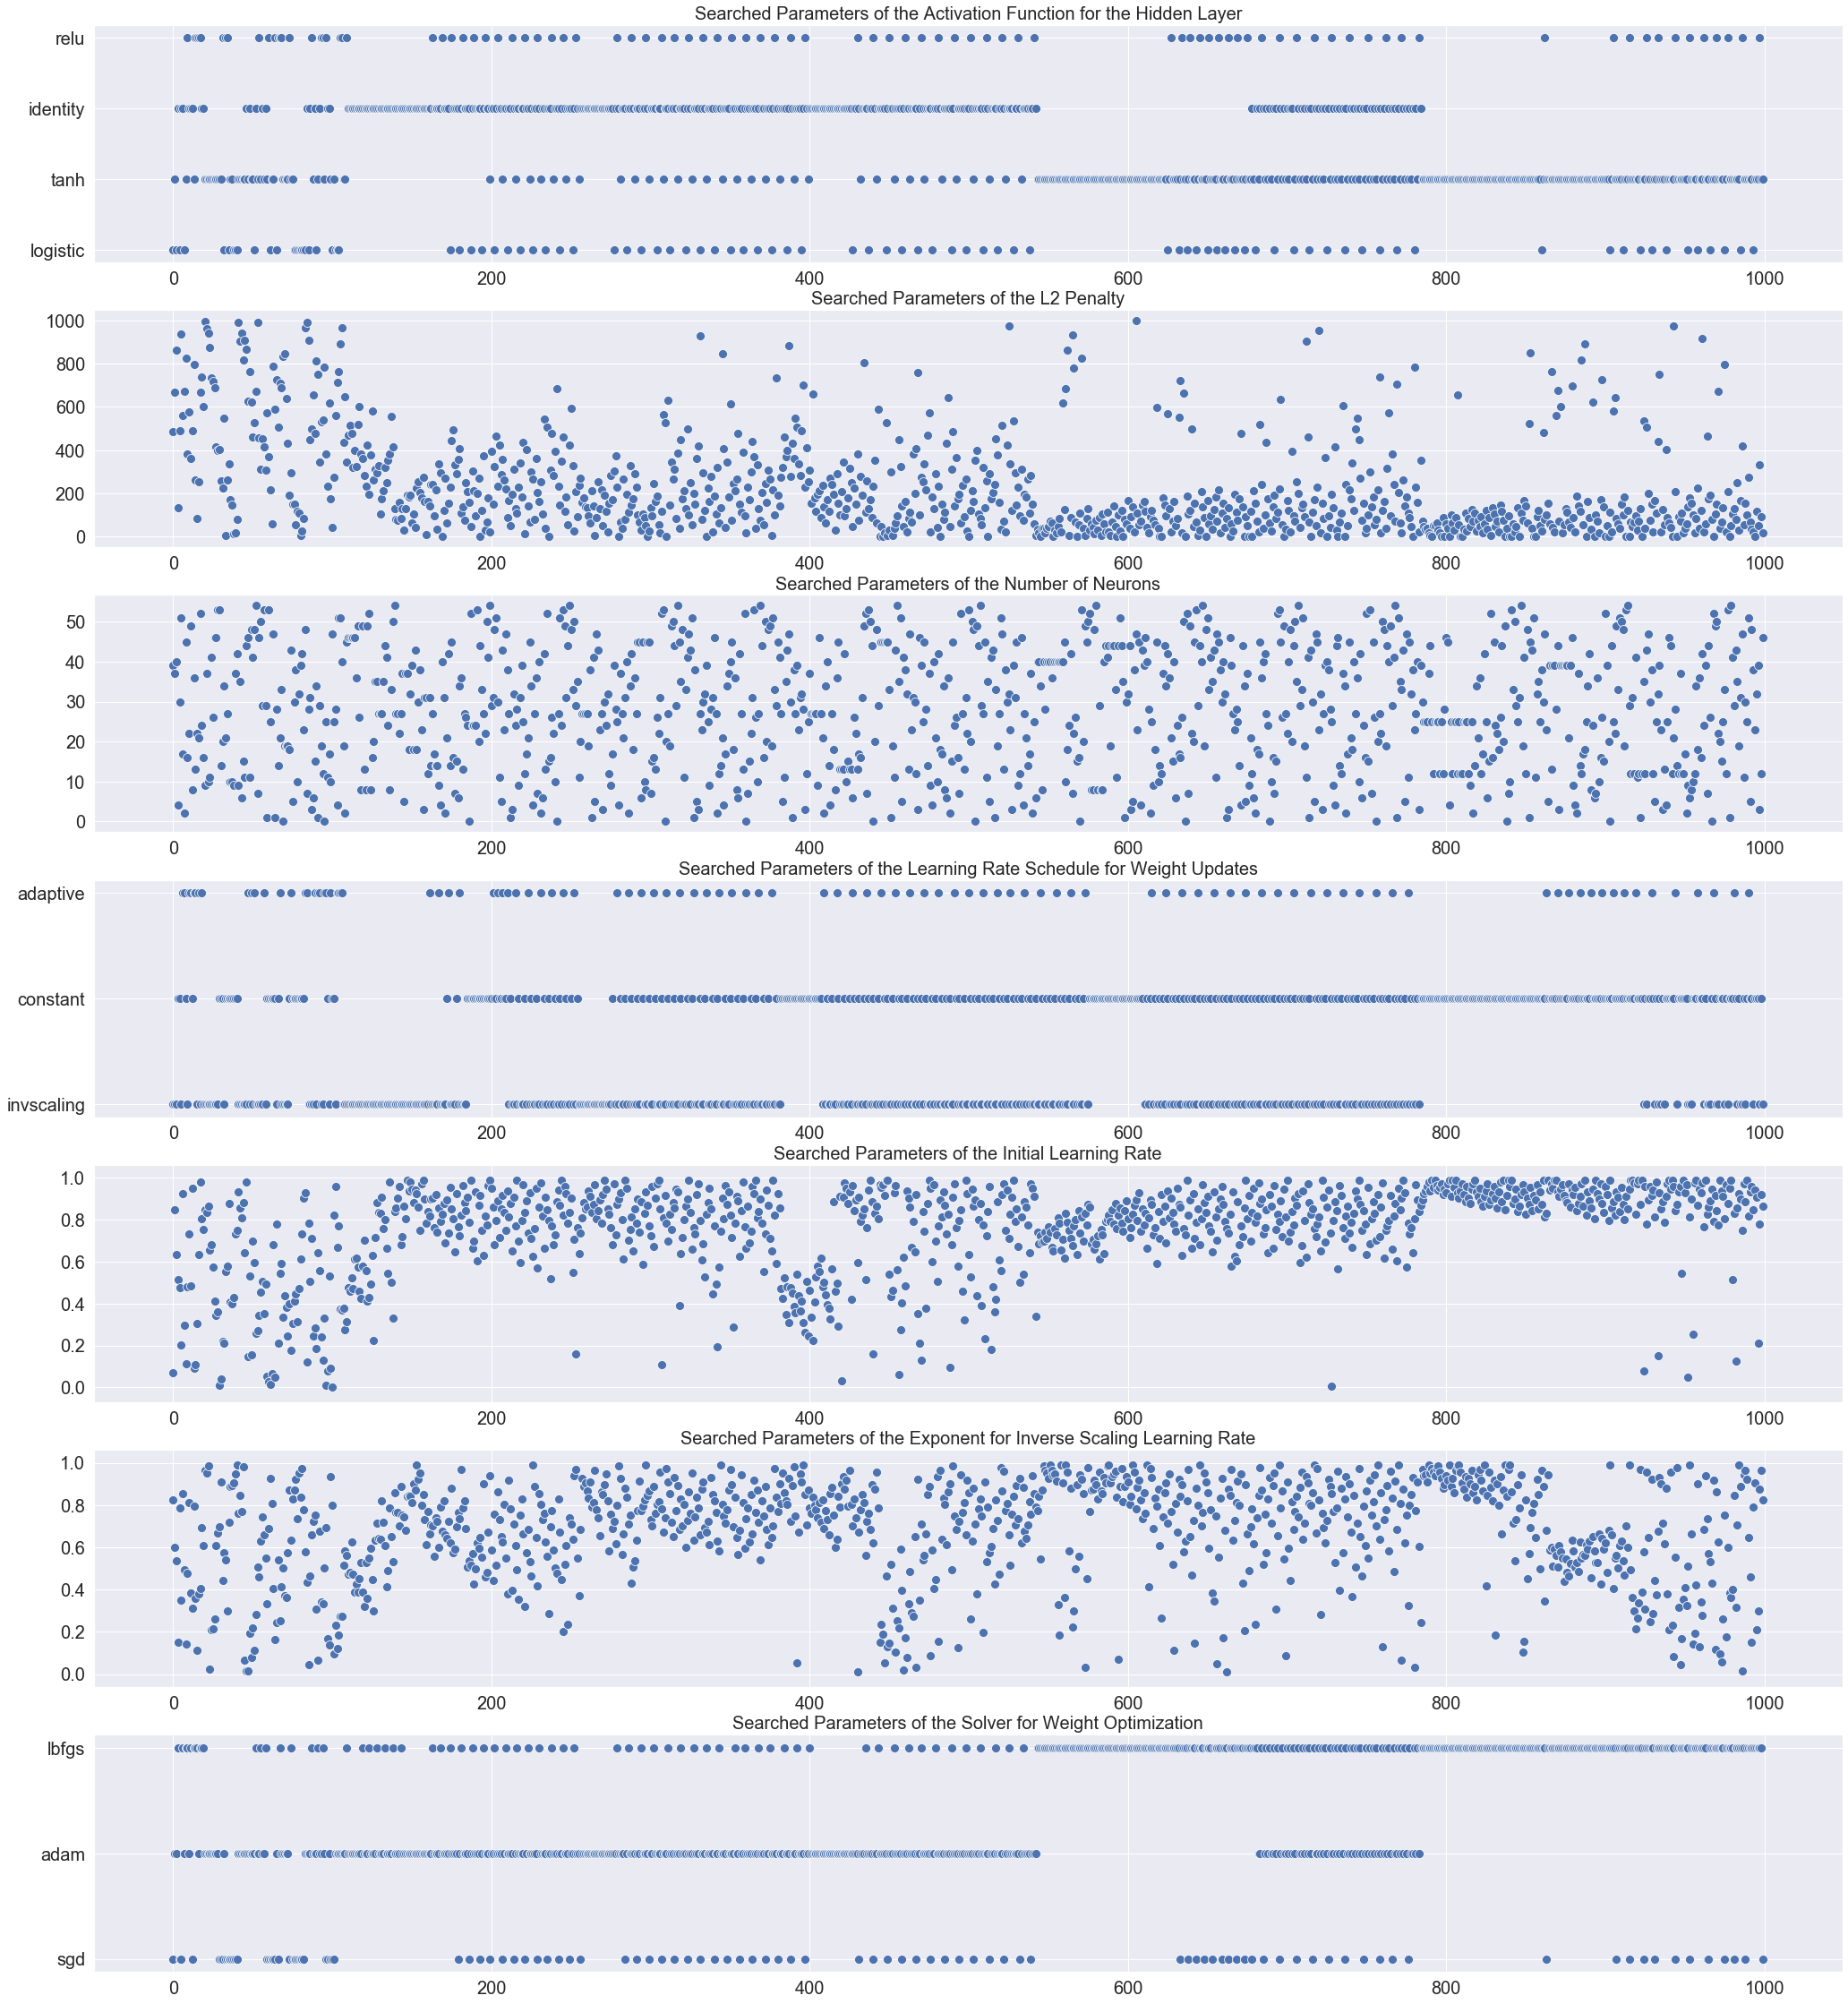

In [8]:
# Set up space dictionary with specified hyperparameters
space = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', range(1,56)),
         'activation': hp.choice('activation', ['logistic','tanh','relu', 'identity']),
         'solver': hp.choice('solver', ['lbfgs','sgd','adam']),
         'alpha': hp.uniform('alpha', 0.0001, 1000),
         'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
         'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.99),
         'power_t': hp.uniform('power_t', 0.01, 0.99)}

target_clf = [None] * 10
target_clf_fitted = [None] * 10
target_y_pred_proba = [None] * 10
target_y_pred = [None] * 10

# Set up objective function
def objective(params):
    params = {'hidden_layer_sizes': params['hidden_layer_sizes'],
              'activation': params['activation'],
              'solver': params['solver'],
              'alpha': params['alpha'],
              'learning_rate': params['learning_rate'],
              'learning_rate_init': params['learning_rate_init'],
              'power_t': params['power_t']}
        
    hyperopt_clf = MLPClassifier(max_iter=4000,
                                 random_state=42,
                                 warm_start=True,
                                 early_stopping=True,
                                 **params)

    best_score = cross_val_score(estimator=hyperopt_clf,
                                 X=X_train,
                                 y=y_train,
                                 cv=3,
                                 n_jobs=4,
                                 pre_dispatch=10).mean()
    
    loss = 1 - best_score
    return {'best_score': best_score, 'loss': loss, 'status': STATUS_OK,'eval_time': time.time()}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
           space=space,
           max_evals=1000,
           rstate=np.random.RandomState(42),
           algo=tpe.suggest,
           trials=trials)
    
best_score = [None] * len(trials.trials)
best_score[0] = trials.results[0].get('best_score')

searched_params_df = pd.DataFrame(trials.trials[0].get('misc').get('vals').values())
searched_params_df = searched_params_df.transpose()

for i in list(range(1, len(trials.trials))):
    new_df = pd.DataFrame(trials.trials[i].get('misc').get('vals').values())
    searched_params_df = searched_params_df.append(new_df.transpose())
    best_score[i] = trials.results[i].get('best_score')

searched_params_df = searched_params_df.rename(columns={0: 'activation', 1: 'alpha', 2: 'hidden_layer_sizes', 
                                                            3: 'learning_rate', 4: 'learning_rate_init', 
                                                            5: 'power_t', 6: 'solver'})
    
blankIndex = [''] * len(searched_params_df)
searched_params_df.index = blankIndex
    
i = ['activation', 'learning_rate', 'solver']
j = ['logistic', 'constant', 'lbfgs']
k = ['tanh', 'invscaling', 'sgd']
l = ['relu', 'adaptive', 'adam']
m = ['identity']

for (i, j, k, l) in zip(i, j, k, l):
    searched_params_df[i] = searched_params_df[i].replace({0: j, 1: k, 2: l, 3: m})

searched_params_df['best_score'] = best_score

searched_params_df_sorted = searched_params_df.sort_values(by='best_score', 
                                                               axis=0, 
                                                               ascending=False)
    
searched_params_df_sorted = searched_params_df_sorted[searched_params_df_sorted.hidden_layer_sizes != 0]

print(searched_params_df_sorted.head(5).transpose())
    
# Learn to predict each class against the other
        
for i in range(5):
    target_clf[i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[i][0],
                                            alpha=searched_params_df_sorted.values[i][1],
                                            hidden_layer_sizes=int(searched_params_df_sorted.values[i][2]),
                                            learning_rate=searched_params_df_sorted.values[i][3],
                                            learning_rate_init=searched_params_df_sorted.values[i][4],
                                            power_t=searched_params_df_sorted.values[i][5],
                                            solver=searched_params_df_sorted.values[i][6])
    

for i in range(5):
    target_clf_fitted[i] = target_clf[i].fit(X_train, y_train)
    target_y_pred_proba[i] = target_clf[i].predict_proba(X_test)
    target_y_pred[i] = target_clf[i].predict(X_test)

# Create the parameter grid
param_grid = {'hidden_layer_sizes': list(product(range(1,56), range(1,56)))}
    
# Create a random search object
ran_clf = RandomizedSearchCV(estimator = MLPClassifier(max_iter=4000,
                                                           random_state=42,
                                                           warm_start=True,
                                                           early_stopping=True,
                                                           activation=searched_params_df_sorted.values[0][0],
                                                           alpha=searched_params_df_sorted.values[0][1],
                                                           learning_rate=searched_params_df_sorted.values[0][3],
                                                           learning_rate_init=searched_params_df_sorted.values[0][4],
                                                           power_t=searched_params_df_sorted.values[0][5],
                                                           solver=searched_params_df_sorted.values[0][6]),
                                 param_distributions=param_grid,
                                 n_iter=465,
                                 n_jobs=4,
                                 pre_dispatch=100,
                                 cv=3,
                                 random_state=42)

ran_clf_fitted = ran_clf.fit(X_train, y_train)

#Configuration of Layer 1 & 2
mean_test_score = list(ran_clf_fitted.cv_results_.get('mean_test_score'))
hidden_layers = list(ran_clf_fitted.cv_results_.get('param_hidden_layer_sizes'))

best_hidden_layers_df = pd.DataFrame({'Hidden Layers': hidden_layers, 'Mean Test Score': mean_test_score})

blankIndex = [''] * len(best_hidden_layers_df)
best_hidden_layers_df.index = blankIndex

# Print out the best configuration of hidden layers
best_hidden_layers_df_sorted = best_hidden_layers_df.sort_values(by='Mean Test Score', 
                                                                     axis=0, 
                                                                     ascending=False)

print(best_hidden_layers_df_sorted.head(5).transpose())

for i in range(5, 10):
      target_clf[i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[0][0],
                                            alpha=searched_params_df_sorted.values[0][1],
                                            hidden_layer_sizes=best_hidden_layers_df_sorted['Hidden Layers'].values[i-6],
                                            learning_rate=searched_params_df_sorted.values[0][3],
                                            learning_rate_init=searched_params_df_sorted.values[0][4],
                                            power_t=searched_params_df_sorted.values[0][5],
                                            solver=searched_params_df_sorted.values[0][6])
    
for i in range(5, 10):
    target_clf_fitted[i] = target_clf[i].fit(X_train, y_train)
    target_y_pred_proba[i] = target_clf[i].predict_proba(X_test)
    target_y_pred[i] = target_clf[i].predict(X_test)

sns.set(rc={'figure.figsize': (35,40), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                'lines.markersize': 10, 'axes.labelsize': 0, 'axes.titlesize': 20})

fig, ax = plt.subplots(7,1)

j = ['Activation Function for the Hidden Layer', 'L2 Penalty', 'Number of Neurons', 
         'Learning Rate Schedule for Weight Updates', 'Initial Learning Rate', 'Exponent for Inverse Scaling Learning Rate',
         'Solver for Weight Optimization']
k = ['activation', 'alpha', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'power_t', 'solver']
    
for (i, j, k) in zip(range(7), j, k):
    
    ax[i].set_title('Searched Parameters of the {}'.format(j))
    sns.scatterplot(x=list(range(0, len(trials.trials))), 
                        y=searched_params_df[k].values, 
                        ax=ax[i])

In [9]:
# Print classification report

i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer', 
     '1stBest_2Layers', '2ndBest_2Layers', '3rdBest_2Layers', '4thBest_2Layers', '5thBest_2Layers']

for (i, j) in zip(i, j):
    print('{}----------'.format(j))
    print()
    print(multilabel_confusion_matrix(y_true=y_test, 
                                      y_pred=target_y_pred[i]))
    print(classification_report(y_true=y_test, 
                                y_pred=target_y_pred[i],
                                digits=2))

1stBest_1Layer----------

[[[   1  113]
  [   0 1074]]

 [[1098    0]
  [  90    0]]

 [[1164    0]
  [  24    0]]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1074
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        24

   micro avg       0.90      0.90      0.90      1188
   macro avg       0.30      0.33      0.32      1188
weighted avg       0.82      0.90      0.86      1188
 samples avg       0.90      0.90      0.90      1188

2ndBest_1Layer----------

[[[  34   80]
  [   4 1070]]

 [[1098    0]
  [  90    0]]

 [[1164    0]
  [  24    0]]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1074
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        24

   micro avg       0.93      0.90      0.92      1188
   macro avg       0.31      0.33      0.32      1188
weighte

In [10]:
# Computing feature importance
print('Best MLP estimator: {}'.format(target_clf[0]))
print()
print('Best results')
print(multilabel_confusion_matrix(y_true=y_test, 
                                  y_pred=target_y_pred[0]))
print(classification_report(y_true=y_test, 
                            y_pred=target_y_pred[0],
                            digits=2))

perm = PermutationImportance(estimator=target_clf[0],
                             n_iter=100,
                             random_state=42).fit(X_test, y_test)

# Create a dataframe of the variables and feature importances
feature_importances_df = pd.DataFrame({'Variable': X.columns, 'Feature_Importances': perm.feature_importances_})

# Print out the top 3 positive variables
feature_importances_df_sorted = feature_importances_df.sort_values(by='Feature_Importances', 
                                                                   axis=0, 
                                                                   ascending=False)
print()
print(feature_importances_df_sorted)

Best MLP estimator: MLPClassifier(activation='tanh', alpha=34.16724692524187, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=40, learning_rate='invscaling',
              learning_rate_init=0.7405276831198528, max_iter=4000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.7736278522078147, random_state=42, shuffle=True,
              solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=True)

Best results
[[[   1  113]
  [   0 1074]]

 [[1098    0]
  [  90    0]]

 [[1164    0]
  [  24    0]]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1074
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        24

   micro avg       0.90      0.90      0.90      1188
   macro avg       0.30      0.33      0.32      1188
weig